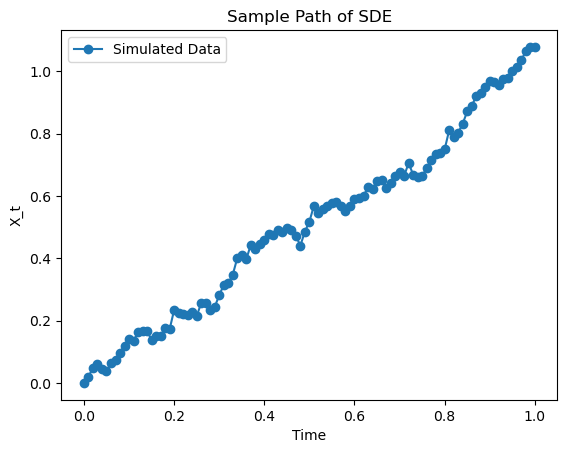

MLE Estimates: a = 1.0786, b = 0.2023
Frequentist Prediction: Mean = 1.6180, Std = 0.1431


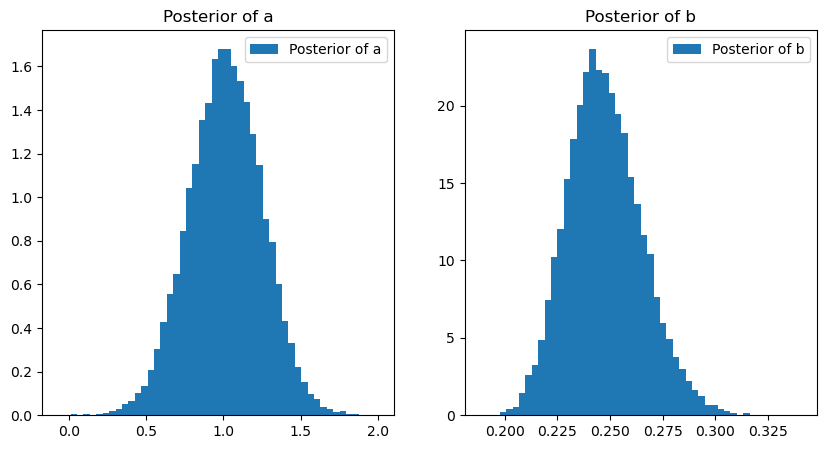

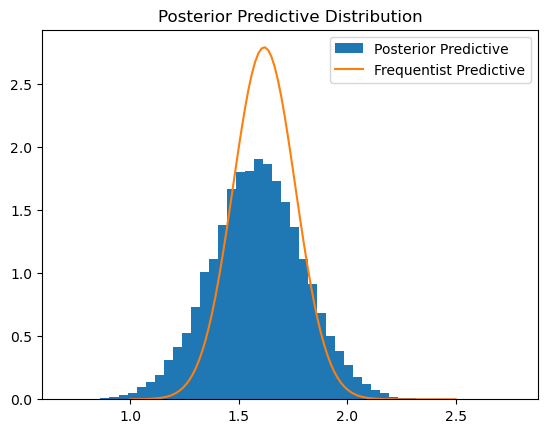

Posterior Means: a = 1.0131, b = 0.2474
Comparison: MLE a = 1.0786, b = 0.2023


In [10]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import invgamma, norm

# Part 1.3: Simulate data from the SDE
def generate_sde_sample(t, x0, a, b):
    N = len(t) - 1
    dt = np.diff(t)
    dW = np.random.normal(0, np.sqrt(dt))
    X = np.zeros(N + 1)
    X[0] = x0
    for n in range(N):
        X[n + 1] = X[n] + a * dt[n] + b * dW[n]
    return X

# Define parameters
x0 = 0
true_a = 1.0
true_b = 0.2
N = 100
t = np.linspace(0, 1, N + 1)

# Generate sample data
observations = generate_sde_sample(t, x0, true_a, true_b)

# Plot the generated data
plt.plot(t, observations, marker="o", label="Simulated Data")
plt.title("Sample Path of SDE")
plt.xlabel("Time")
plt.ylabel("X_t")
plt.legend()
plt.show()

# Part 1.4: Maximum Likelihood Estimation
def mle_estimation(t, observations):
    dt = np.diff(t)
    dx = np.diff(observations)

    # MLE for a
    a_mle = np.sum(dx) / np.sum(dt)

    # MLE for b
    b_mle_squared = np.sum((dx - a_mle * dt)**2 / dt) / len(dt)
    b_mle = np.sqrt(b_mle_squared)

    return a_mle, b_mle

# Compute MLE estimates
a_mle, b_mle = mle_estimation(t, observations)
print(f"MLE Estimates: a = {a_mle:.4f}, b = {b_mle:.4f}")

# Part 1.5: Predictive distribution
def frequentist_predictive(X_N, t_N, t_next, a_mle, b_mle):
    mean = X_N + a_mle * (t_next - t_N)
    variance = (b_mle**2) * (t_next - t_N)
    return mean, np.sqrt(variance)

# Predict at t_next = 1.5
t_next = 1.5
mean_pred, std_pred = frequentist_predictive(observations[-1], t[-1], t_next, a_mle, b_mle)

print(f"Frequentist Prediction: Mean = {mean_pred:.4f}, Std = {std_pred:.4f}")

# Part 2.3: Bayesian Estimation (Gibbs Sampling)
def gibbs_sampling(observations, t, num_iter=20000, burn_in=100):
    dt = np.diff(t)
    dx = np.diff(observations)
    
    # Priors
    sigma_prior = 1.0
    alpha_prior = 1.0
    beta_prior = 1.0

    # Initialize samples
    a_samples = []
    b_samples = []

    # Initial values
    a = np.random.normal(0, sigma_prior)
    b_squared = invgamma.rvs(a=alpha_prior, scale=beta_prior)

    for _ in range(num_iter):
        # Sample a | b
        sigma_squared = 1 / (1 / sigma_prior**2 + np.sum(dt) / b_squared)
        mu = sigma_squared * np.sum(dx / b_squared)
        a = np.random.normal(mu, np.sqrt(sigma_squared))
        
        # Sample b^2 | a
        alpha_post = alpha_prior + len(dx) / 2
        beta_post = beta_prior + 0.5 * np.sum((dx - a * dt)**2 / dt)
        b_squared = invgamma.rvs(a=alpha_post, scale=beta_post)

        # Store samples
        a_samples.append(a)
        b_samples.append(np.sqrt(b_squared))

    # Remove burn-in
    a_samples = np.array(a_samples[burn_in:])
    b_samples = np.array(b_samples[burn_in:])

    return a_samples, b_samples

# Perform Gibbs sampling
a_samples, b_samples = gibbs_sampling(observations, t)

# Plot posterior samples
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(a_samples, bins=50, density=True, label="Posterior of a")
plt.title("Posterior of a")
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(b_samples, bins=50, density=True, label="Posterior of b")
plt.title("Posterior of b")
plt.legend()
plt.show()

# Posterior Predictive Distribution
def posterior_predictive(a_samples, b_samples, X_N, t_N, t_next):
    predictions = []
    for a, b in zip(a_samples, b_samples):
        mean = X_N + a * (t_next - t_N)
        variance = b**2 * (t_next - t_N)
        predictions.append(np.random.normal(mean, np.sqrt(variance)))
    return predictions

posterior_predictions = posterior_predictive(a_samples, b_samples, observations[-1], t[-1], t_next)

# Plot predictive distribution
plt.hist(posterior_predictions, bins=50, density=True, label="Posterior Predictive")

# Plot frequentist predictive distribution
x = np.linspace(1., 2.5, 100)
pdf = norm.pdf(x, mean_pred, std_pred)
plt.plot(x, pdf, label="Frequentist Predictive")
plt.title("Posterior Predictive Distribution")
plt.legend()
plt.show()

# Compare posterior mean to MLE
a_post_mean = np.mean(a_samples)
b_post_mean = np.mean(b_samples)
print(f"Posterior Means: a = {a_post_mean:.4f}, b = {b_post_mean:.4f}")
print(f"Comparison: MLE a = {a_mle:.4f}, b = {b_mle:.4f}")

In [11]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Function to generate frequentist plot
def generate_frequentist_plot(t, observations, a_mle, b_mle, t_next, mean_pred, std_pred):
    plt.figure(figsize=(10, 6))
    plt.plot(t, observations, marker="o", label="Observed Data", color="blue")
    plt.axvline(t_next, linestyle="--", color="gray", label="Prediction Time")

    # Plot predictive mean and confidence intervals
    pred_time = [t[-1], t_next]
    pred_values = [observations[-1], mean_pred]
    plt.plot(pred_time, pred_values, linestyle="--", color="red", label="Frequentist Prediction")

    lower_bound = mean_pred - 1.96 * std_pred
    upper_bound = mean_pred + 1.96 * std_pred
    plt.fill_between([t[-1], t_next], [observations[-1], lower_bound], [observations[-1], upper_bound], 
                     color="red", alpha=0.2, label="95% Confidence Interval")

    plt.title("Frequentist Prediction")
    plt.xlabel("Time")
    plt.ylabel("X_t")
    plt.legend()
    plt.savefig("frequentist_plot.pdf")
    plt.close()

# Function to generate Bayesian plot
def generate_bayesian_plot(posterior_predictions):
    plt.figure(figsize=(10, 6))
    plt.hist(posterior_predictions, bins=50, density=True, color="green", alpha=0.6, label="Posterior Predictive")
    mean_post = np.mean(posterior_predictions)
    std_post = np.std(posterior_predictions)

    # Overlay Gaussian approximation
    x = np.linspace(min(posterior_predictions), max(posterior_predictions), 500)
    plt.plot(x, norm.pdf(x, mean_post, std_post), color="black", linestyle="--", label="Gaussian Fit")

    plt.title("Posterior Predictive Distribution")
    plt.xlabel("Predicted Value")
    plt.ylabel("Density")
    plt.legend()
    plt.savefig("bayesian_plot.pdf")
    plt.close()

# Example usage (uses values from previous computations):
# Simulate some data (reusing earlier variables)
x0 = 0
true_a = 1.0
true_b = 0.1
N = 100
t = np.linspace(0, 1, N + 1)
observations = generate_sde_sample(t, x0, true_a, true_b)

a_mle, b_mle = mle_estimation(t, observations)
t_next = 1.5
mean_pred, std_pred = frequentist_predictive(observations[-1], t[-1], t_next, a_mle, b_mle)
posterior_predictions = posterior_predictive(a_samples, b_samples, observations[-1], t[-1], t_next)

# Generate the plots
generate_frequentist_plot(t, observations, a_mle, b_mle, t_next, mean_pred, std_pred)
generate_bayesian_plot(posterior_predictions)